
# 1 El análisis

In [3]:
import os
import winsound
import special_fun as s
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal as signal
import pywt
from scipy.signal import firwin
#Para que me avise
duration = 1000 
freq = 440 

## 1.1 Carga obtención de los audios

In [25]:
ruta_carpeta = '../Data/audio_and_txt_files'
#Si es en colab
#ruta_carpeta = "/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files" 
lista_archivos = os.listdir(ruta_carpeta)
datos=s.sonido_probando123(lista_archivos,ruta_carpeta)

## Ejemplo del metodo usado

In [26]:
y,sr=librosa.load(list(datos.keys())[20])

In [27]:
def mfreqz(b,a,order,nyq_rate,xlim):
    
    """
    Plot the impulse response of the filter in the frequency domain

    Parameters:
        
        b: numerator values of the transfer function (coefficients of the filter)
        a: denominator values of the transfer function (coefficients of the filter)
        
        order: order of the filter 
                
        nyq_rate = nyquist frequency
    """
    
    w,h = signal.freqz(b,a);
    h_dB = 20 * np.log10 (abs(h));
    
    plt.figure();

    plt.subplots_adjust(hspace=0.8)

    plt.subplot(311);
    plt.plot((w/max(w))*nyq_rate,abs(h));
    plt.ylabel('Magnitude');
    plt.title(r'Frequency response. Order: ' + str(order));
    [xmin, xmax, ymin, ymax] = plt.axis();
    plt.xlim((0,xlim))
    
    plt.grid(True);
    
    plt.subplot(312);
    plt.plot((w/max(w))*nyq_rate,h_dB);
    plt.ylabel('Magnitude (db)');
    plt.title(r'Frequency response. Order: ' + str(order));
    plt.grid(True)
    plt.grid(True)
    plt.xlim((0,xlim))

    
    plt.subplot(313);
    h_Phase = np.unwrap(np.arctan2(np.imag(h),np.real(h)));
    plt.plot((w/max(w))*nyq_rate,h_Phase);
    plt.ylabel('Phase (radians)');
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)');
    plt.title(r'Phase response. Order: ' + str(order));
    plt.xlim((0,xlim))

    plt.subplots_adjust(hspace=0.5);
    plt.grid(True)
    plt.show()

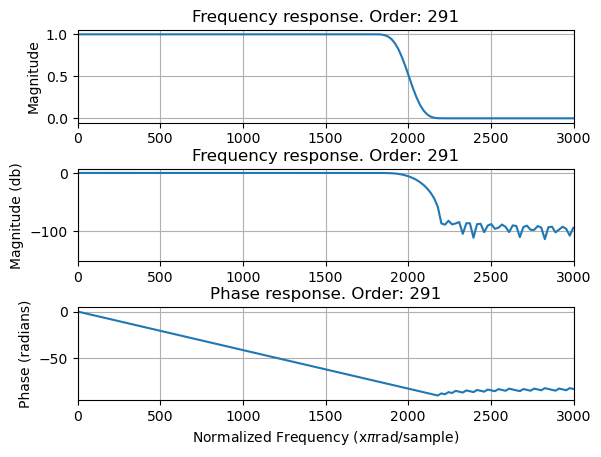

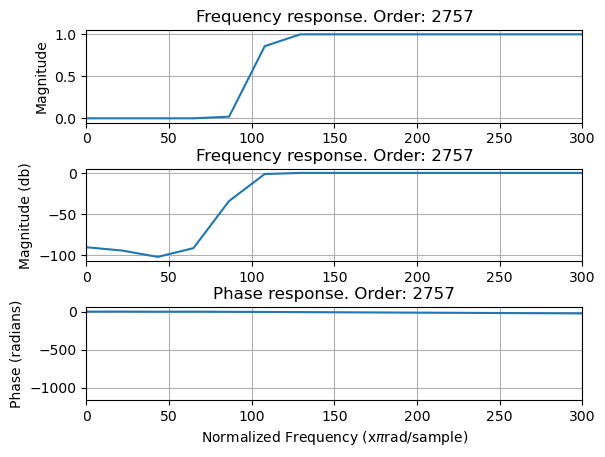

In [28]:
high=100
low=2000
nyq=sr/2
bandalp=(low-high)*0.1
ordenlp=int(5*(nyq/bandalp))
if ordenlp%2==0:
    ordenlp+=1

low_pass=firwin(ordenlp, low/nyq ,window=('kaiser',7.85))
mfreqz(low_pass,1,ordenlp, nyq,3000)

bandahp=(high)*0.2
ordenhp= int(5*(nyq/bandahp))
if ordenhp%2==0:
    
    ordenhp+=1

high_pass=firwin(ordenhp, high/nyq ,pass_zero="highpass",window=('kaiser',7.85))
mfreqz(high_pass,1,ordenhp, nyq,300)

In [29]:
y_h = signal.filtfilt(high_pass, 1, y)
y_l = signal.filtfilt(low_pass, 1, y_h)
yfir = np.asfortranarray(y_l)

Text(0, 0.5, 'Potencia')

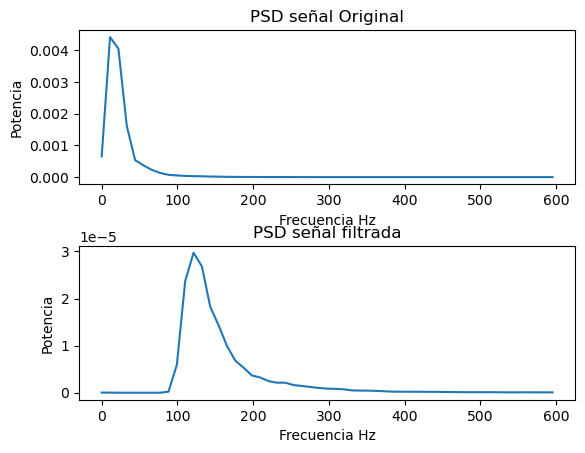

In [30]:
plt.figure()
plt.subplots_adjust(hspace=0.4)
plt.subplot(211)
f,Pxx=signal.welch(y,sr,"hamming",2000,1000,scaling="density")
r=f<600
plt.plot(f[r],Pxx[r])
plt.title("PSD señal Original")
plt.xlabel("Frecuencia Hz")
plt.ylabel("Potencia")


plt.subplot(212)
f,Pxx=signal.welch(yfir,sr,"hamming",2000,1000,scaling="density")
r=f<600
plt.plot(f[r],Pxx[r])
plt.title("PSD señal filtrada")
plt.xlabel("Frecuencia Hz")
plt.ylabel("Potencia")


In [31]:
data_wavelet = pywt.wavedec( yfir, 'db6', level=8 )  
details = data_wavelet[1:]
details_t = s.wthresh(details)
rec=list()
rec.append(data_wavelet[0])
for i in range(len(details_t)): 
    rec.append(details_t[i]) 
x_rec = pywt.waverec( rec, 'db6') 
x_rec = x_rec[0:y.shape[0]]
y_fil=np.squeeze(yfir - x_rec)

Text(0.5, 1.0, 'Discriminación ciclos cardíacos')

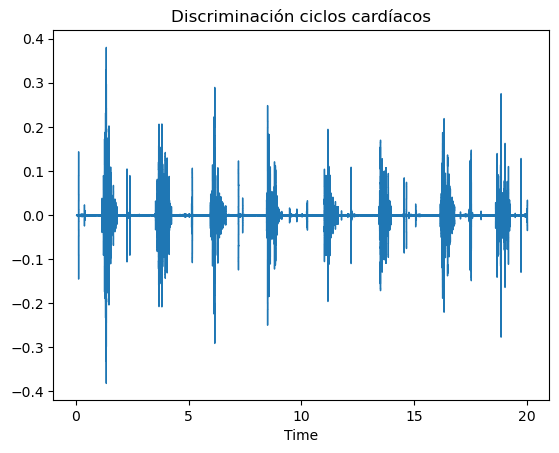

In [32]:
librosa.display.waveshow(x_rec,sr=sr)
plt.title("Discriminación ciclos cardíacos")

Text(0, 0.5, 'Potencia')

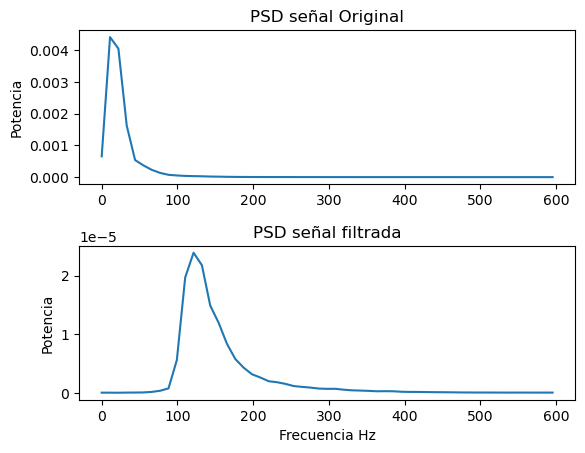

In [33]:
plt.figure()
plt.subplots_adjust(hspace=0.4)
plt.subplot(211)
f,Pxx=signal.welch(y,sr,"hamming",2000,1000,scaling="density")
r=f<600
plt.plot(f[r],Pxx[r])
plt.title("PSD señal Original")
plt.ylabel("Potencia")


plt.subplot(212)
f,Pxx=signal.welch(y_fil,sr,"hamming",2000,1000,scaling="density")
r=f<600
plt.plot(f[r],Pxx[r])
plt.title("PSD señal filtrada")
plt.xlabel("Frecuencia Hz")
plt.ylabel("Potencia")


# Generación de espectros

In [34]:
def custom_filter(fs,low=2000,high=100):
    nyq=fs/2
    bandalp=(low-high)*0.1
    ordenlp=int(5*(nyq/bandalp))
    if ordenlp%2==0:
        ordenlp+=1

    low_pass=firwin(ordenlp, low/nyq ,window=('kaiser',7.85))

    bandahp=(high)*0.2
    ordenhp= int(5*(nyq/bandahp))
    if ordenhp%2==0:
        ordenhp+=1
    high_pass=firwin(ordenhp, high/nyq ,pass_zero="highpass",window=('kaiser',7.85))

    return low_pass,high_pass

In [35]:
low_pass,high_pass=custom_filter(datos[list(datos.keys())[0]][1])

In [36]:
def el_filtrador(data,low_pass,high_pass,nivel=10):
    y_h = signal.filtfilt(high_pass, 1, data)
    y_l = signal.filtfilt(low_pass, 1, y_h)
    y = np.asfortranarray(y_l)
    data_wavelet = pywt.wavedec( y, 'db6', level=nivel )  
    details = data_wavelet[1:]
    details_t = s.wthresh(details)
    rec=list()
    rec.append(data_wavelet[0])
    for i in range(len(details_t)): 
        rec.append(details_t[i]) 
    x_rec = pywt.waverec( rec, 'db6') 
    x_rec = x_rec[0:y.shape[0]]
    y_fil=np.squeeze(y - x_rec)
    return y_fil

In [37]:
def filtrar_todo(datos,low_pass,high_pass,level=10):
    fil={}
    for i in list(datos.keys()):
        y_fil=el_filtrador(datos[i][0],low_pass,high_pass,nivel=10)
        fil[i]=y_fil
    return fil

In [38]:
fil=filtrar_todo(datos,low_pass,high_pass,10)
winsound.Beep(freq, duration)

In [39]:
def welch_a(data,sr,rate):
    f,Pxx=signal.welch(data,sr,"hamming",rate[0],rate[1])
    return Pxx[f<1000]

In [40]:
def ciclos(datos,fil,fs,welchrate):
    sound_sanos=[]
    sound_crep=[]
    sound_sil=[]
    welch_sanos=[]
    welch_crep=[]
    welch_sil=[]
    los_wav=list(datos.keys())
    los_txt=[i.replace(".wav",".txt") for i in los_wav]
    for i in range(len(los_txt)):
        d=pd.read_csv(los_txt[i],sep="\t",header=None,names=["ini","end","crackles","wheezes"])
        for index,row in d.iterrows():
            paciente=los_wav[i]
            filti=fil[paciente]
            ini=int(row["ini"]*fs)
            fin=int(row["end"]*fs)
            ciclo=filti[ini:fin]
            if len(ciclo)>=40000:
                ciclo=ciclo[:40001]
                guelch=welch_a(ciclo,sr,welchrate)
                if (int(row["wheezes"])==1) & (int(row["crackles"])==0):
                    sound_sil.append(ciclo)
                    welch_sil.append(guelch)
                if (int(row["crackles"])==1) & (int(row["wheezes"])==0):
                    sound_crep.append(ciclo)
                    welch_crep.append(guelch)
                if (int(row["wheezes"])==0) & (int(row["crackles"])==0):
                    sound_sanos.append(ciclo)
                    welch_sanos.append(guelch)
    return sound_sanos,sound_crep,sound_sil,welch_sanos,welch_crep,welch_sil


In [41]:
sound_sanos,sound_crep,sound_sil,welch_sanos,welch_crep,welch_sil=ciclos(datos,fil,sr,[2000,1000])

In [42]:
print(len(sound_sanos))
print(len(sound_crep))
print(len(sound_sil))


2633
1631
655


(0.0, 500.0)

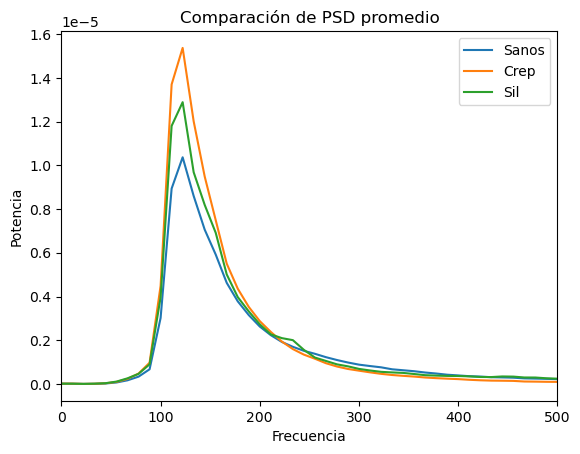

In [43]:
a=plt.figure()
prom=[welch_sanos,welch_crep,welch_sil]
new_prom=[]
f=np.linspace(0,1000,len(prom[0][0]))
for i in prom:
    new_prom.append(np.mean(i,axis=0))
for i in new_prom:
    plt.plot(f,i)
plt.title("Comparación de PSD promedio")
plt.legend(["Sanos","Crep","Sil"])
plt.ylabel("Potencia")
plt.xlabel("Frecuencia")
plt.xlim(0,500)


In [44]:
df=pd.DataFrame( np.array(new_prom))
df.to_csv("promedios.csv",index=False)

In [45]:
prom= np.loadtxt('promedios.csv', delimiter=',')
promedios=prom[1:]

## Rangos de comparación para la PSD

Text(0.5, 0, 'Frecuencia [Hz]')

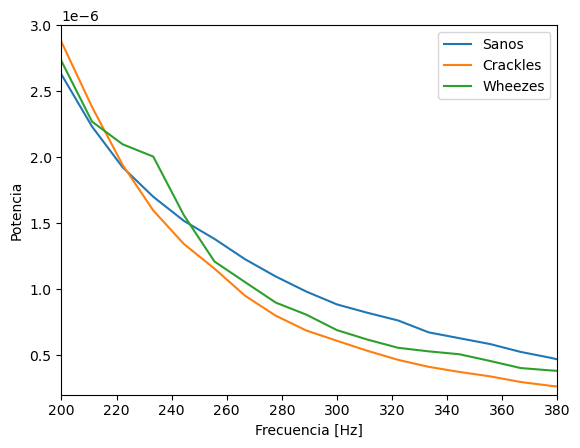

In [46]:
s.grafiquelo(new_prom,[200,380],[0.2e-6,3e-6])
plt.ylabel("Potencia")
plt.xlabel("Frecuencia [Hz]")

Text(0.5, 0, 'Frecuencia [Hz]')

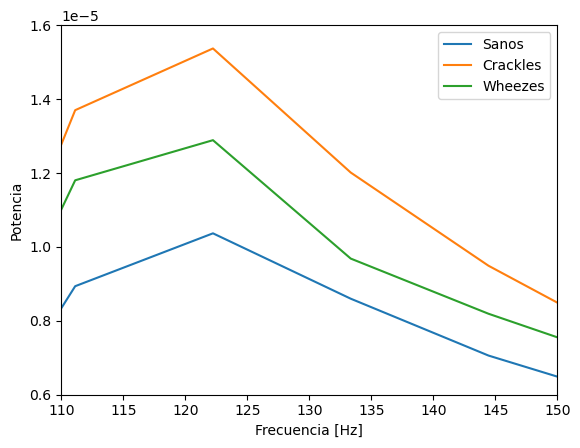

In [68]:
s.grafiquelo(new_prom,[110,150],[0.6e-5,1.6e-5])
plt.ylabel("Potencia")
plt.xlabel("Frecuencia [Hz]")

Text(0.5, 0, 'Frecuencia [Hz]')

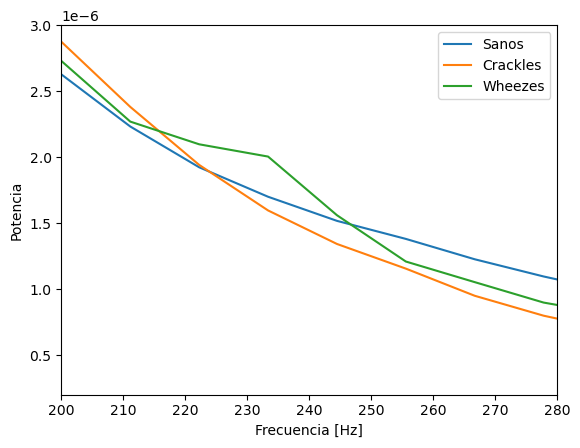

In [47]:
s.grafiquelo(new_prom,[200,280],[0.2e-6,3e-6])
plt.ylabel("Potencia")
plt.xlabel("Frecuencia [Hz]")

In [48]:
guelch=[welch_sanos,welch_crep,welch_sil]
listas=[sound_sanos,sound_crep,sound_sil]

In [49]:
def el_fraccionador(data,fmin=75,fmax=250):
    new_data=[]
    for paciente in data:
        new_ciclo=[]
        for ciclo in paciente:
                f=np.linspace(0,1000,len(ciclo))
                r=(fmax>f) & (fmin>f)
                new_ciclo.append(ciclo[r])
        new_data.append(new_ciclo)
    return new_data

In [50]:
def el_finalizador(data,data_sound,fmin=350,fmax=600):
    def sumatoria(data_frac):
            sum_datos.append(np.sum(data_frac))
    def mediana(data):
            mediana_datos.append(np.median(data))
    def varianza(sound_data,estado):
            var_datos.append(np.var(sound_data))
            fin_estado.append(estado)
    data_frac=el_fraccionador(data,fmin,fmax)
    estado=["Healthy","Crackles","Wheezes"]
    fin_estado=[]
    sum_datos=[]
    mediana_datos=[]
    var_datos=[]
    for i in range(len(estado)):
        status=estado[i]
        a_data=data[i]
        sound_data=data_sound[i]
        a_data_frac=data_frac[i]
        for ciclo in range(len(a_data)):
            sumatoria(a_data_frac[ciclo])
            mediana(a_data[ciclo])
            varianza(sound_data[ciclo],status)
    d={}
    d["Estado"]=fin_estado
    d["Sumatoria"]=sum_datos
    d["Mediana"]=mediana_datos
    d["Varianza"]=var_datos
    d=pd.DataFrame(d)
    return d

In [51]:
d=el_finalizador(guelch,listas,200,280)
d

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,5.556148e-07,4.686493e-10,0.000008
1,Healthy,6.529095e-07,2.819616e-10,0.000009
2,Healthy,6.096350e-07,2.985569e-10,0.000009
3,Healthy,5.567451e-07,2.556868e-10,0.000008
4,Healthy,5.016411e-07,3.071286e-10,0.000007
...,...,...,...,...
4914,Wheezes,1.017147e-05,1.164674e-08,0.000136
4915,Wheezes,9.649835e-06,8.796041e-09,0.000129
4916,Wheezes,1.124116e-06,7.448796e-10,0.000015
4917,Wheezes,9.903341e-07,4.516410e-10,0.000013


In [52]:
d.to_csv("Data_set_200_280.csv",index=False)

In [69]:
d2=el_finalizador(guelch,listas,110,130)
d2

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,1.593746e-07,4.686493e-10,0.000008
1,Healthy,1.817279e-07,2.819616e-10,0.000009
2,Healthy,1.673060e-07,2.985569e-10,0.000009
3,Healthy,1.265948e-07,2.556868e-10,0.000008
4,Healthy,1.288562e-07,3.071286e-10,0.000007
...,...,...,...,...
4914,Wheezes,3.523871e-07,1.164674e-08,0.000136
4915,Wheezes,4.289128e-07,8.796041e-09,0.000129
4916,Wheezes,8.466170e-08,7.448796e-10,0.000015
4917,Wheezes,6.115781e-08,4.516410e-10,0.000013


In [70]:
d2.to_csv("Data_set_110_130.csv",index=False)

## Estadistica

In [53]:
#libreria para manejo de NDARRAY
import scipy as sp
#libreria para graficar
import matplotlib.pyplot as plt
#Lector de archivos csv
from csv import reader as reader_csv;
import scipy.signal as signal;
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols
import pandas as pd
import sympy as sym

from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import mannwhitneyu
from scipy.stats import levene
import pingouin as pg


In [54]:
def check_normality2(data):

    pVals = pd.Series('p-value')
    # The scipy normaltest is based on D-Agostino and Pearsons test that
    # combines skew and kurtosis to produce an omnibus test of normality.

    _, pVals['Kolmogorov-Smirnov']   = stats.kstest((data-np.mean(data))/np.std(data,ddof=1), 'norm')
    
    return pVals['Kolmogorov-Smirnov'] 

In [55]:
def normality_table2(data):
    names=data.columns.values
    sano={"Estado":["Healthy",'Kolmogorov-Smirnov']}
    psano=sum(data["Estado"]=="Healthy")
    pcrackles=sum(data["Estado"]=="Crackles")
    pwheezes=sum(data["Estado"]=="Wheezes")
    for i in names[1:]:
        
        c=data.loc[0:psano-1,i]
        x=check_normality2(c)
        if x>0.05:
            sano[i]=[True,x]
        else:
            sano[i]=[False,x]
    san=pd.DataFrame.from_dict(sano)
    cracles={"Estado":["Crackles",'Kolmogorov-Smirnov']}
    for i in names[1:]: 

        c=data.loc[psano:pcrackles+psano-1,i]
        x=check_normality2(c)
        if x>0.05:
            cracles[i]=[True,x]
        else:
            cracles[i]=[False,x]
    cra=pd.DataFrame.from_dict(cracles)
    wheezes={"Estado":["Wheezes",'Kolmogorov-Smirnov']}
    for i in names[1:]:

        c=data.loc[pcrackles+psano:pcrackles+psano+pwheezes,i]
        x=check_normality2(c)
        if x>0.05:
            wheezes[i]=[True,x]
        else:
            wheezes[i]=[False,x]
    whe=pd.DataFrame.from_dict(wheezes)
    return pd.concat([san,cra,whe],ignore_index=True)

In [56]:
def prueba_u(data):
    sano,crakles,wheezes = [data[data['Estado']=='Healthy'], data[data['Estado']=='Crackles'],data[data['Estado']=='Wheezes']]
    names=data.columns.values
    namest=names[1:]
 
    stat1, p1 = mannwhitneyu(sano[namest],crakles[namest])
    stat2, p2 = mannwhitneyu(sano[namest],wheezes[namest])

    con=0
    for i in p1: 
        print('Sano vs crepitancias')
        print('Statistics=%.3f, p=%.3e for channel %s' % (stat1[con], i,namest[con]))
        con+=1
        #interpret
        alpha = 0.05
        if i > alpha:
            print('Same distribution (fail to reject H0)')
        else:
            print('Different distribution (reject H0)')
    con=0
    for i in p2: 
        print('Sano vs sibilancias')
        print('Statistics=%.3f, p=%.3e for channel %s' % (stat2[con], i,namest[con]))
        con+=1
        #interpret
        alpha = 0.05
        if i > alpha:
            print('Same distribution (fail to reject H0)')
        else:
            print('Different distribution (reject H0)')

In [57]:
def walli(data):
    sano,crakles,wheezes = [data[data['Estado']=='Healthy'], data[data['Estado']=='Crackles'],data[data['Estado']=='Wheezes']]
    names=data.columns.values
    namest=names[1:]
    con=0
    stat,p = stats.kruskal(sano[namest],crakles[namest],wheezes[namest])
    con=0
    for i in p: 
        print('Statistics=%.3f, p=%.3e for channel %s' % (stat[con], i,namest[con]))
        con+=1
        #interpret
        alpha = 0.05
        if i > alpha:
            print('Same distribution (fail to reject H0)')
        else:
            print('Different distribution (reject H0)')

In [58]:
def caja_bigotes2(data1,data2,data3,var):

    # Crear una lista de nombres para las etiquetas del gráfico
    labels = ['Healthy', 'Crackles','Wheezes']

    plt.boxplot([data1[var], data2[var], data3[var]], labels=labels)
    plt.title(var)
    plt.show()

# Rango entre 200 y 280

In [59]:
d3=pd.read_csv("Data_set_200_280.csv")

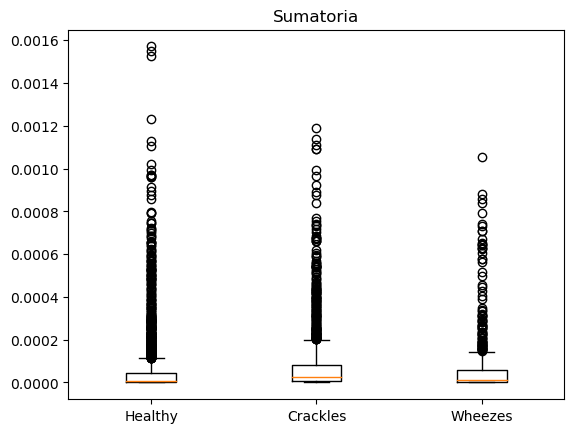

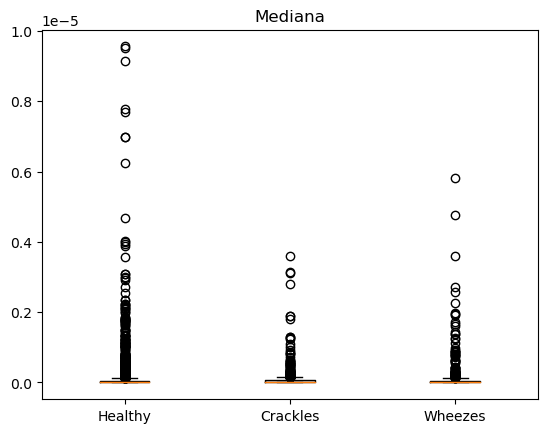

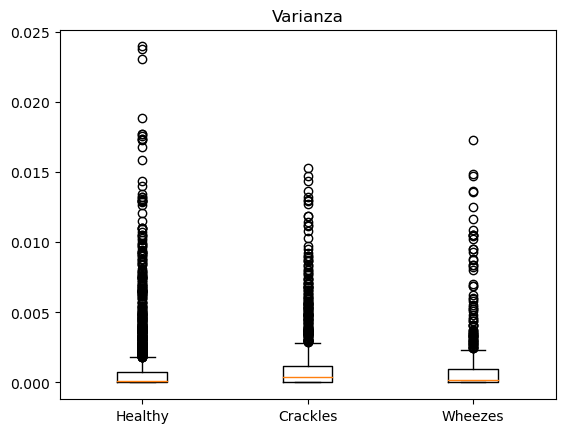

In [60]:
sano,crakles,wheezes = [d3[d3['Estado']=='Healthy'], d3[d3['Estado']=='Crackles'],d3[d3['Estado']=='Wheezes']]
caja_bigotes2(sano,crakles,wheezes,'Sumatoria')
caja_bigotes2(sano,crakles,wheezes,'Mediana')
caja_bigotes2(sano,crakles,wheezes,'Varianza')

In [61]:
prueba_u(d3)
print("--------")
print("walli")
walli(d3)
ns=normality_table2(d3)
ns

Sano vs crepitancias
Statistics=1598895.000, p=9.532e-45 for channel Sumatoria
Different distribution (reject H0)
Sano vs crepitancias
Statistics=1820862.000, p=6.635e-17 for channel Mediana
Different distribution (reject H0)
Sano vs crepitancias
Statistics=1650796.000, p=5.446e-37 for channel Varianza
Different distribution (reject H0)
Sano vs sibilancias
Statistics=771172.000, p=2.768e-05 for channel Sumatoria
Different distribution (reject H0)
Sano vs sibilancias
Statistics=811643.000, p=1.979e-02 for channel Mediana
Different distribution (reject H0)
Sano vs sibilancias
Statistics=777871.000, p=1.029e-04 for channel Varianza
Different distribution (reject H0)
--------
walli
Statistics=197.551, p=1.266e-43 for channel Sumatoria
Different distribution (reject H0)
Statistics=69.709, p=7.292e-16 for channel Mediana
Different distribution (reject H0)
Statistics=162.346, p=5.585e-36 for channel Varianza
Different distribution (reject H0)


,Estado,Sumatoria,Mediana,Varianza
0,Healthy,False,False,False
1,Kolmogorov-Smirnov,0.0,0.0,0.0
2,Crackles,False,False,False
3,Kolmogorov-Smirnov,0.0,0.0,0.0
4,Wheezes,False,False,False
5,Kolmogorov-Smirnov,0.0,0.0,0.0


# Transformada de Potencia

In [111]:
d=d3.copy()
transformada1,lamda1=stats.boxcox(d3.loc[0:,['Sumatoria']].values.reshape(1,-1)[0])
transformada2,lamda2=stats.boxcox(d3.loc[0:,['Mediana']].values.reshape(1,-1)[0])
transformada3,lamda3=stats.boxcox(d3.loc[0:,['Varianza']].values.reshape(1,-1)[0])
d["Sumatoria"]=-transformada1
d['Mediana']=-transformada2
d['Varianza']=-transformada3

In [112]:
d.to_csv("Data_set_200_280_Boxcox.csv",index=False)

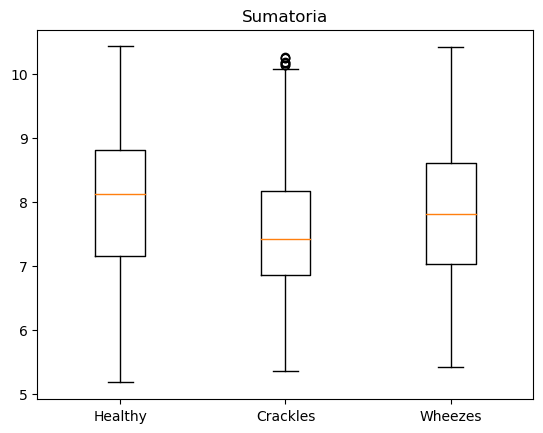

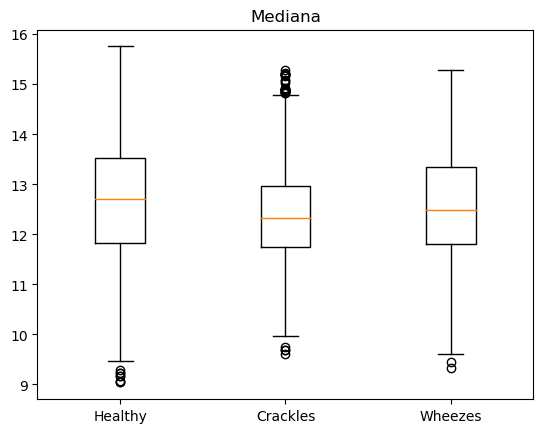

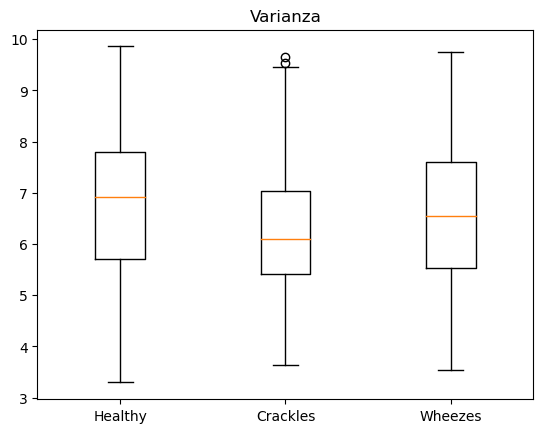

In [63]:
sano,crakles,wheezes = [d[d['Estado']=='Healthy'], d[d['Estado']=='Crackles'],d[d['Estado']=='Wheezes']]
caja_bigotes2(sano,crakles,wheezes,'Sumatoria')
caja_bigotes2(sano,crakles,wheezes,'Mediana')
caja_bigotes2(sano,crakles,wheezes,'Varianza')

In [64]:
print('Prueba U Mann-Withney')
prueba_u(d)
print("--------")
print("Prueba de Walli")
walli(d)
print("--------")
print("Prueba de Normalidad")
ns=normality_table2(d)
ns

Prueba U Mann-Withney
Sano vs crepitancias
Statistics=2695528.000, p=9.532e-45 for channel Sumatoria
Different distribution (reject H0)
Sano vs crepitancias
Statistics=2473561.000, p=6.635e-17 for channel Mediana
Different distribution (reject H0)
Sano vs crepitancias
Statistics=2643627.000, p=5.446e-37 for channel Varianza
Different distribution (reject H0)
Sano vs sibilancias
Statistics=953443.000, p=2.768e-05 for channel Sumatoria
Different distribution (reject H0)
Sano vs sibilancias
Statistics=912972.000, p=1.979e-02 for channel Mediana
Different distribution (reject H0)
Sano vs sibilancias
Statistics=946744.000, p=1.029e-04 for channel Varianza
Different distribution (reject H0)
--------
Prueba de Walli
Statistics=197.551, p=1.266e-43 for channel Sumatoria
Different distribution (reject H0)
Statistics=69.709, p=7.292e-16 for channel Mediana
Different distribution (reject H0)
Statistics=162.346, p=5.585e-36 for channel Varianza
Different distribution (reject H0)
--------
Prueba de

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,False,True,False
1,Kolmogorov-Smirnov,0.000003,0.058898,0.0
2,Crackles,False,False,False
3,Kolmogorov-Smirnov,0.000118,0.000116,0.000046
4,Wheezes,True,True,False
5,Kolmogorov-Smirnov,0.074417,0.169838,0.033474


Se Realiza una prueba de Levene para verificar la homogeneidad de las distribuciones de los dos grupos que dieron positivo en la prueba de normalidad

In [65]:
sano,wheezes = [d[d['Estado']=='Healthy'],d[d['Estado']=='Wheezes']]
c=sano['Mediana']
p=wheezes['Mediana']

p_valor = levene(c, p).pvalue
if p_valor > 0.05:
    print("Los datos son homocedásticos.")
else:
    print("Los datos no son homocedásticos.")
print(p_valor)

Los datos no son homocedásticos.
0.010413910313505742


# Para rango 110 a 130

In [78]:
d2=pd.read_csv("Data_set_110_130.csv")

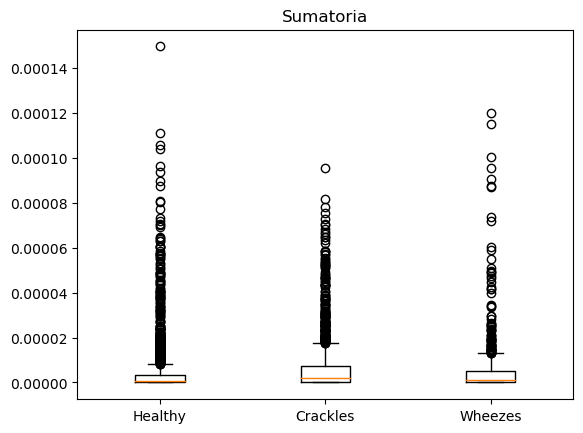

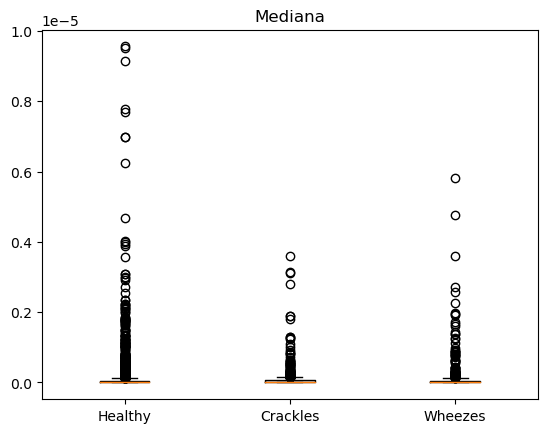

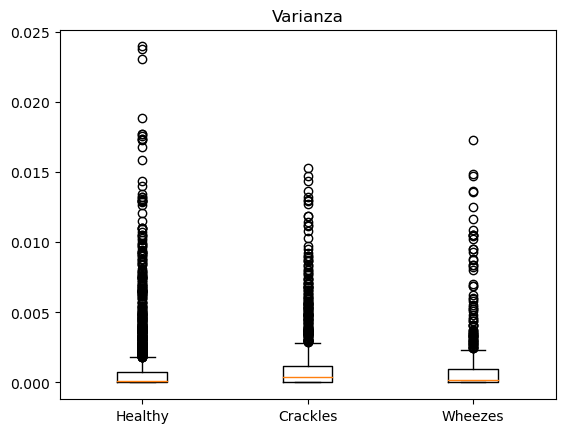

In [72]:
sano,crakles,wheezes = [d2[d2['Estado']=='Healthy'], d2[d2['Estado']=='Crackles'],d2[d2['Estado']=='Wheezes']]
caja_bigotes2(sano,crakles,wheezes,'Sumatoria')
caja_bigotes2(sano,crakles,wheezes,'Mediana')
caja_bigotes2(sano,crakles,wheezes,'Varianza')

In [82]:
d4=d2.copy()
transformada1,lamda1=stats.boxcox(d2.loc[0:,['Sumatoria']].values.reshape(1,-1)[0])
transformada2,lamda2=stats.boxcox(d2.loc[0:,['Mediana']].values.reshape(1,-1)[0])
transformada3,lamda3=stats.boxcox(d2.loc[0:,['Varianza']].values.reshape(1,-1)[0])
d4["Sumatoria"]=-transformada1
d4['Mediana']=-transformada2
d4['Varianza']=-transformada3

In [83]:
print('Prueba U Mann-Withney')
prueba_u(d4)
print("--------")
print("Prueba de Walli")
walli(d4)
print("--------")
print("Prueba de Normalidad")
ns=normality_table2(d4)
ns

Prueba U Mann-Withney
Sano vs crepitancias
Statistics=2737744.000, p=1.280e-51 for channel Sumatoria
Different distribution (reject H0)
Sano vs crepitancias
Statistics=2473561.000, p=6.635e-17 for channel Mediana
Different distribution (reject H0)
Sano vs crepitancias
Statistics=2643627.000, p=5.446e-37 for channel Varianza
Different distribution (reject H0)
Sano vs sibilancias
Statistics=968477.000, p=1.043e-06 for channel Sumatoria
Different distribution (reject H0)
Sano vs sibilancias
Statistics=912972.000, p=1.979e-02 for channel Mediana
Different distribution (reject H0)
Sano vs sibilancias
Statistics=946744.000, p=1.029e-04 for channel Varianza
Different distribution (reject H0)
--------
Prueba de Walli
Statistics=229.805, p=1.255e-50 for channel Sumatoria
Different distribution (reject H0)
Statistics=69.709, p=7.292e-16 for channel Mediana
Different distribution (reject H0)
Statistics=162.346, p=5.585e-36 for channel Varianza
Different distribution (reject H0)
--------
Prueba de

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,False,True,False
1,Kolmogorov-Smirnov,0.000035,0.058898,0.0
2,Crackles,True,False,False
3,Kolmogorov-Smirnov,0.19651,0.000116,0.000046
4,Wheezes,True,True,False
5,Kolmogorov-Smirnov,0.057645,0.169838,0.033474


En este caso no se obtuvo normalidad en la sumatoria para este rango por lo que no se realiza la prueba de normalidad

Según la prueba U y la prueba de Walli, las medianas de los datos tienen diferencias estadísticamente significativas. Por lo que se procede a realizarce una rutina de Machine learning para hacer un sistema capaz de clasificar los 3 tipos de ciclos respiratorios a partir de la sumatoria del PSD en un rango específico, de la mediana del PSD o de la varianza de la señal en el tiempo

# Machine Learning

In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix

In [25]:
d2=pd.read_csv("Data_set_200_280.csv")

In [26]:
dfsano={}
dfcrackles={}

sanosum = d2[d2['Estado']=='Healthy']['Sumatoria']
craklessum= d2[d2['Estado']=='Crackles']['Sumatoria']

dfsano['Sumatoria'] = sanosum
dfsano['Outcome'] = 0

dfcrackles['Sumatoria'] = craklessum
dfcrackles['Outcome'] = 1

dfsano=pd.DataFrame(dfsano)
dfcrackles=pd.DataFrame(dfcrackles)

df_sum_crackles = pd.concat([dfsano, dfcrackles], ignore_index=True)

df_sum_crackles


,Sumatoria,Outcome
0,5.556148e-07,0
1,6.529095e-07,0
2,6.096350e-07,0
3,5.567451e-07,0
4,5.016411e-07,0
...,...,...
4259,4.609957e-07,1
4260,4.886190e-07,1
4261,5.237399e-07,1
4262,4.681218e-07,1


In [27]:
#%% Step 3 - Creating Arrays for the Features and the Response Variable
target_column = ['Outcome'] 
predictors = list(set(list(df_sum_crackles.columns))-set(target_column))
print(predictors)

#Sets are used to store multiple items in a single variable.
#Set is one of 4 built-in data types in Python used to store collections of data, 
#the other 3 are List, Tuple, and Dictionary, all with different qualities and usage.
#A set is a collection which is both unordered and unindexed.

#The variables are normalized
df_sum_crackles[predictors] = df_sum_crackles[predictors]/df_sum_crackles[predictors].max()
df_sum_crackles.describe()

['Sumatoria']


,Sumatoria,Outcome
count,4264.000000,4264.000000
mean,0.041254,0.382505
std,0.089378,0.486056
min,0.000004,0.000000
25%,0.001029,0.000000
50%,0.006757,0.000000
75%,0.037786,1.000000
max,1.000000,1.000000


In [28]:
#%% Step 4 - Creating the Training and Test Datasets
X = df_sum_crackles[predictors].values
y = df_sum_crackles[target_column].values

#the same seed is used to partition to obtain the same results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=300)
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)
print('Datos de entrenamiento')
print(X_train.shape)
print(y_train.shape)

print('Datos de Validación')

print(X_test.shape)
print(y_test.shape)

Datos de entrenamiento
(2984, 1)
(2984,)
Datos de Validación
(1280, 1)
(1280,)


In [29]:
y_train.s

AttributeError: 'numpy.ndarray' object has no attribute 's'

In [ ]:
#Three hidden layer each layer with eigth neurons
mlp = MLPClassifier(hidden_layer_sizes=(2,2), activation='relu', solver='adam', max_iter=10000) 
print(mlp)

MLPClassifier(hidden_layer_sizes=(2, 2), max_iter=10000)


In [ ]:
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

In [ ]:
from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
target_names = ['Sano','Crakles']

Confusion matrix, without normalization
[[1827    0]
 [1157    0]]


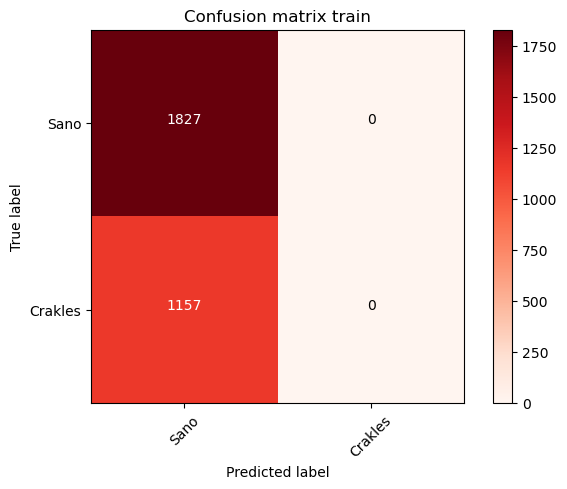

In [ ]:
mc_train = confusion_matrix(y_train,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix train')

In [ ]:
print(classification_report(y_train,predict_train,target_names=target_names))

              precision    recall  f1-score   support

        Sano       0.61      1.00      0.76      1827
     Crakles       0.00      0.00      0.00      1157

    accuracy                           0.61      2984
   macro avg       0.31      0.50      0.38      2984
weighted avg       0.37      0.61      0.47      2984



c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization
[[806   0]
 [474   0]]


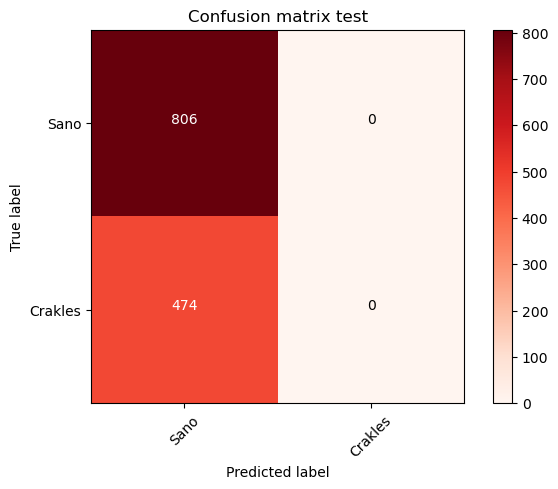

In [ ]:
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,
                      title='Confusion matrix test')

In [ ]:
print(classification_report(y_test,predict_test,target_names=target_names))

              precision    recall  f1-score   support

        Sano       0.63      1.00      0.77       806
     Crakles       0.00      0.00      0.00       474

    accuracy                           0.63      1280
   macro avg       0.31      0.50      0.39      1280
weighted avg       0.40      0.63      0.49      1280



c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn import svm

clf = svm.NuSVC(gamma='auto')
clf.fit(X_train,y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

target_names = ['Sano', 'Crackles']
print(classification_report(y_train,predict_train,target_names=target_names))

print(classification_report(y_test,predict_test,target_names=target_names))

              precision    recall  f1-score   support

        Sano       0.63      0.89      0.74      1827
    Crackles       0.49      0.17      0.25      1157

    accuracy                           0.61      2984
   macro avg       0.56      0.53      0.49      2984
weighted avg       0.57      0.61      0.55      2984

              precision    recall  f1-score   support

        Sano       0.64      0.89      0.75       806
    Crackles       0.47      0.16      0.23       474

    accuracy                           0.62      1280
   macro avg       0.55      0.53      0.49      1280
weighted avg       0.58      0.62      0.56      1280

